# Project: Portfolio Optimization using Sharpe Ratio

This project aims to optimize a portfolio of stocks by maximizing the **Sharpe Ratio**, which measures return per unit of risk.

### Key Objectives:
- Fetch historical stock price data
- Calculate log returns and annualized metrics
- Optimize portfolio weights using `scipy.optimize`
- Visualize the **Efficient Frontier**
- Analyze portfolio risk with **VaR** and **CVaR**
  
This notebook demonstrates how to construct a portfolio that offers the best risk-adjusted returns.


In [20]:
# Import all libraries
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt

from pprint import pprint
from sklearn.preprocessing import StandardScaler

In [21]:
# Set display options for Pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

###  Data and Stock Selection

For this analysis, we have selected historical stock data from **01-01-2020 to 30-04-2021**, a period that includes the economic fluctuations during the **COVID-19 pandemic**. This timeframe allows us to observe how different sectors performed under high uncertainty and market stress.

We have chosen **five representative stocks** from the **NIFTY 50 index**, carefully selected to ensure **diversified industry exposure**:

- **TCS** (Technology)
- **ONGC** (Oil & Energy)
- **ITC** (FMCG & Conglomerate)
- **HDFC** (Financial Services)
- **CIPLA** (Pharmaceuticals)

This selection helps create a portfolio that spans across major sectors of the Indian economy, making the optimization more robust and generalizable across different market conditions.


In [22]:
# Define the symbols
symbols =['TCS', 'ONGC', 'ITC', 'HDFC', 'CIPLA']

# Number of stocks in our portfolio
number_of_symbols=len(symbols)

# Load Stock Data CSV file
price_data_frame = pd.read_csv("Stock_Data.csv", parse_dates=['Date'], dayfirst=True)

#Sort by dates 
price_data_frame = price_data_frame.sort_values('Date')

print(price_data_frame.head())


           Date Symbol     Open    High      Low    Close   Volume
0    2020-01-01    TCS  2168.00  2183.9  2154.00  2167.60  1354908
332  2020-01-01   ONGC   128.75   128.9   126.85   127.45  2574894
1328 2020-01-01  CIPLA   481.00   481.0   474.45   475.90  1316812
996  2020-01-01   HDFC  2418.00  2438.5  2409.00  2433.95   945874
664  2020-01-01    ITC   238.60   238.6   237.10   238.10  4208837


In [23]:
#Grab the columns we need
price_data_frame=price_data_frame[['Date','Symbol', 'Close']]

#Pivot the Data Frame to make the symbols as the Headers
price_data_frame=price_data_frame.pivot(index='Date', columns='Symbol', values='Close')

display(price_data_frame)

Symbol,CIPLA,HDFC,ITC,ONGC,TCS
Date,,,,,
2020-01-01,475.90,2433.95,238.10,127.45,2167.60
2020-01-02,473.50,2466.40,239.85,128.05,2157.65
2020-01-03,469.95,2454.45,238.50,128.45,2200.65
2020-01-06,466.75,2384.10,235.10,126.25,2200.45
2020-01-07,468.60,2415.05,235.35,125.75,2205.85
...,...,...,...,...,...
2021-04-26,905.40,2509.80,205.30,102.80,3100.80
2021-04-27,912.40,2518.40,205.40,103.20,3132.00
2021-04-28,910.20,2577.00,205.50,103.90,3124.10


In [24]:
price_data_frame.head(5)

Symbol,CIPLA,HDFC,ITC,ONGC,TCS
Date,,,,,
2020-01-01,475.90,2433.95,238.10,127.45,2167.60
2020-01-02,473.50,2466.40,239.85,128.05,2157.65
2020-01-03,469.95,2454.45,238.50,128.45,2200.65
2020-01-06,466.75,2384.10,235.10,126.25,2200.45
2020-01-07,468.60,2415.05,235.35,125.75,2205.85


### Data Preprocessing and Return Calculation

Once the stock price data is loaded and sorted by date, the next step is to calculate the **logarithmic returns** of each asset. Log returns are preferred over simple percentage returns in financial analysis because they are time-additive, handle compounding naturally, and better reflect the continuous nature of market pricing.

Calculating log returns helps us understand the day-to-day change in stock prices and forms the foundation for further portfolio analysis, including optimization, risk evaluation, and performance metrics.


In [25]:
# Calculate the Log returns (better metric to visualize returns over time)
log_return=np.log(1+price_data_frame.pct_change())

In [26]:
# Generate an initial guess for the weights using random values
# These will be normalized later to sum to 1
random_weights = np.array(np.random.random(number_of_symbols))

### Volatility and Sharpe Ratio

Once we compute the log returns, two essential metrics for evaluating a portfolio’s performance are:

#### **Volatility (Risk)**
Volatility measures the **standard deviation of returns** — it quantifies the degree of variation or risk in the portfolio’s returns. A higher volatility indicates greater uncertainty or fluctuations in value, while a lower volatility implies more stable performance.

Mathematically, for a portfolio with given weights and a covariance matrix of asset returns, volatility is calculated as:

$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

Where:
- $w$ = vector of asset weights
- $\Sigma$ = covariance matrix of log returns

#### **Sharpe Ratio (Risk-Adjusted Return)**
The Sharpe Ratio measures **how much excess return** the portfolio generates for each unit of risk (volatility). It helps answer the question: *Are we being rewarded adequately for the risk we're taking?*

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Where:
- $R_p$ = expected portfolio return
- $R_f$ = risk-free rate (often assumed 0 for simplicity)
- $\sigma_p$ = portfolio volatility

In this project, we aim to **maximize the Sharpe Ratio** to find the optimal asset allocation that gives the best return for the least risk.


In [51]:
#Display
display(random_weights)

#Set the sum of random weights=1  (Can be slightly off)
rebalance_weights=random_weights/np.sum(random_weights)

#Calculate the expected returns (Annualized; 252 trading days)
exp_ret=np.sum((log_return.mean()*rebalance_weights)*252)

#Calculate expected volatility (Annualized; 252 trading days)
exp_vol = np.sqrt(np.dot(rebalance_weights.T, np.dot(log_return.cov() * 252, rebalance_weights)))

#Calculate Sharpe Ratio (Taking Risk Free Return =7% based on 10 year Indian Government Bond Yield)
sharpe_ratio= exp_ret-0.07/exp_vol

#Put the weights into dataframes for better visualization and readability
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


array([0.59462748, 0.10726529, 0.63158399, 0.37355049, 0.33418975])


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.594627           0.291310
1        0.107265           0.052550
2        0.631584           0.309415
3        0.373550           0.183004
4        0.334190           0.163721
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.124694                       0.278249               -0.126879
--------------------------------------------------------------------------------


### Monte Carlo Simulation for Portfolio Optimization

Monte Carlo Simulation is a powerful technique used to understand the behavior of a system through **random sampling**. In the context of portfolio optimization, we use it to:

- Generate **thousands of random portfolios** by assigning random weights to each asset.
- Calculate the **expected return**, **volatility**, and **Sharpe Ratio** for each portfolio.
- Visualize the distribution of possible portfolios on a **risk-return (efficient frontier) plot**.

By simulating a large number of possible allocations, we can identify:
- The **portfolio with the highest Sharpe Ratio** (maximum risk-adjusted return)
- The **portfolio with the lowest volatility** (minimum risk)

Monte Carlo simulation does not guarantee the perfect allocation, but it provides a **comprehensive view** of how different combinations perform, helping us make more informed investment decisions.


In [28]:
#Monte Carlo Simulation: Find the best possible percentage holdings given how much risk to take

#Number of simulations for Monte Carlo
num_of_simulations=10000

#Prepare the arrays to store values of the simulations
all_weights=np.zeros((num_of_simulations,number_of_symbols))
ret_arr=np.zeros(num_of_simulations)
vol_arr=np.zeros(num_of_simulations)
sharpe_arr=np.zeros(num_of_simulations)

#Start the simulation
for ind in range(num_of_simulations):

    weights=np.array(np.random.random(number_of_symbols))
    weights=weights/np.sum(weights)

    all_weights[ind, :]= weights

    #Calculate the expected Log returns
    ret_arr[ind]=np.sum((log_return.mean()*weights)*252)

    #Calculate the volatility
    vol_arr[ind]=np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252,weights)))

    #Calculate the Sharpe Ration
    sharpe_arr[ind]=(ret_arr[ind]-0.07)/vol_arr[ind]

#Combine all together to create a master dataframe
simulations_data=[ret_arr, vol_arr, sharpe_arr,all_weights]
simulations_df=pd.DataFrame(data=simulations_data).T

#Formatting
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

#Checking datatypes
simulations_df = simulations_df.infer_objects()

#Print the results
simulations_df = simulations_df.infer_objects()
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                                         Portfolio Weights
0  0.122924    0.291905      0.181306   [0.3471903814875002, 0.15321295331794993, 0.24023335097374465, 0.2224078964209518, 0.03695541779985336]
1  0.098424    0.287538      0.098853   [0.2676179428031032, 0.1156304547366149, 0.28587068664338106, 0.21742156579108887, 0.11345935002581202]
2  0.025235    0.320391     -0.139719  [0.14456837770557635, 0.2968142665913817, 0.22319044068472066, 0.27118814134835334, 0.06423877366996793]
3  0.175246    0.265790      0.395975   [0.3637803376688917, 0.148101038180791, 0.28653116290724867, 0.053010803270975175, 0.14857665797209343]
4  0.105404    0.280503      0.126218   [0.19456918315502103, 0.08222338180071002, 0.26397019371019925, 0.1982757814014133, 0.2609614599326564]
----------------------------------

In [29]:
#Find the max sharpe ratio
max_sharpe_ratio=simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

#Return portfolio with the least volatility
min_volatility=simulations_df.loc[simulations_df['Volatility'].idxmin()]

#Formatting
print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                                                                                0.389942
Volatility                                                                                                             0.310286
Sharpe Ratio                                                                                                            1.03112
Portfolio Weights    [0.7677840032077576, 0.13039209397867613, 0.019151729591924037, 0.019607694906909404, 0.06306447831473279]
Name: 599, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                                                                                 0.224395
Volatility                                             

### Data Visualization: Portfolio Risk and Return

To interpret the results of our Monte Carlo simulation, we use a key plot:

#### Efficient Frontier Plot (Sharpe Ratio Colored)

- **X-axis**: Portfolio Volatility (Risk)
- **Y-axis**: Expected Portfolio Return
- **Color**: Sharpe Ratio (risk-adjusted return)

This plot shows **10,000 simulated portfolios**, with each point representing a different combination of asset weights.  
The color gradient highlights how the **Sharpe Ratio** varies — the brighter (more yellow/green) the point, the better the return per unit of risk.

We also mark:
- 🟢**Max Sharpe Ratio Portfolio** — highest risk-adjusted return
- 🔵 **Min Volatility Portfolio** — least risky portfolio

This plot helps us visualize the **Efficient Frontier**, where optimal portfolios lie in the top-left region of the graph — offering the best return for a given risk level.

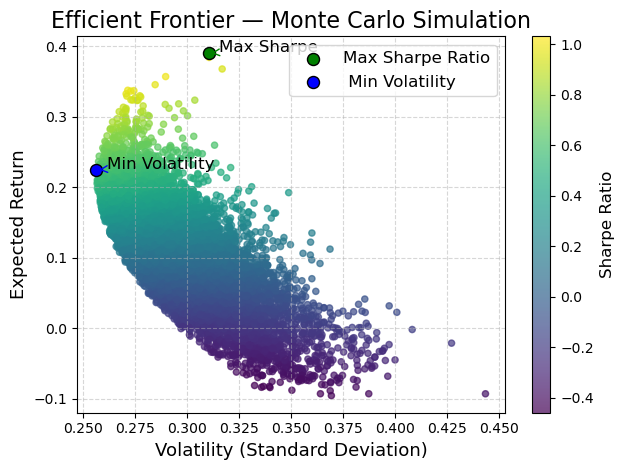

In [30]:
# Identify optimal portfolios
max_sharpe_idx = sharpe_arr.argmax()
min_vol_idx = vol_arr.argmin()

# Scatter of all simulations
scatter = plt.scatter(
    vol_arr, ret_arr,
    c=sharpe_arr,
    cmap='viridis',
    alpha=0.7,
    s=20
)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', fontsize=12)

# 🟢 Max Sharpe Ratio portfolio
plt.scatter(
    vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx],
    color='green',
    edgecolors='black',
    marker='.',
    s=300,
    label='Max Sharpe Ratio'
)

# 🔵 Min Volatility portfolio
plt.scatter(
    vol_arr[min_vol_idx], ret_arr[min_vol_idx],
    color='blue',
    edgecolors='black',
    marker='.',
    s=300,
    label=' Min Volatility'
)

# Annotations
plt.annotate('Max Sharpe', 
             xy=(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx]),
             xytext=(vol_arr[max_sharpe_idx] + 0.005, ret_arr[max_sharpe_idx] + 0.002),
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=12)

plt.annotate('Min Volatility', 
             xy=(vol_arr[min_vol_idx], ret_arr[min_vol_idx]),
             xytext=(vol_arr[min_vol_idx] + 0.005, ret_arr[min_vol_idx] + 0.002),
             arrowprops=dict(arrowstyle='->', color='blue'),
             fontsize=12)

# Labels and layout
plt.title('Efficient Frontier — Monte Carlo Simulation', fontsize=16)
plt.xlabel('Volatility (Standard Deviation)', fontsize=13)
plt.ylabel('Expected Return', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Optimization Functions

To find the most optimal portfolio allocation, we define a set of helper functions that will be used by the optimization algorithm:

- `get_metrics(weights)`: Computes the **expected return**, **volatility**, and **Sharpe Ratio** of the portfolio for a given set of weights.
- `grab_negative_sharpe(weights)`: Since `scipy.optimize` only supports minimization, we maximize the Sharpe Ratio by minimizing its **negative value**.
- `grab_volatility(weights)`: Returns the **portfolio volatility** to help us find the portfolio with **minimum risk**.
- `check_sum(weights)`: A **constraint function** to ensure that the total weight of all stocks equals 1 (i.e., full capital allocation).

These functions allow us to use optimization techniques to find the most efficient portfolio based on risk-return tradeoffs.



In [52]:
#Optimization of the Portfolio

#Predefine some functions to help with optimization

def get_metrics(weights:list)-> np.array:
    #Convert the weights to a numpy array
    weights=np.array(weights)

    #Calculate the returns
    ret=np.sum(log_return.mean()*weights*252)

    #Calculate the volatility
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

    # Calculate the Sharpe Ratio.
    sr=ret/vol

    return np.array([ret, vol, sr])

#SciPy doesnt not have a maximise function

#Maximise sharpe ratio by minimising negative sharpe ratio
def grab_negative_sharpe(weights: list) -> np.array:
    
    return -get_metrics(weights)[2]

#Return minimum volatility
def grab_volatility(weights: list) -> np.array:

    return get_metrics(weights)[1]

#Check if weights=1
def check_sum(weights: list) -> float:

    return np.sum(weights) - 1

### Sequential Least Squares Programming (SLSQP)

For optimizing our portfolio, we use the **Sequential Least Squares Programming (SLSQP)** algorithm — a powerful method for solving nonlinear optimization problems with both **equality and inequality constraints**.

#### SLSQP benenfits: 
- It allows us to define constraints such as:
  - All portfolio weights must **sum to 1**
  - No short selling (weights between 0 and 1)
- It supports **bounded optimization**, which makes it suitable for portfolio allocation tasks where weights must remain within a valid range.
- SLSQP is available through `scipy.optimize.minimize()` and is particularly effective for financial optimization problems.

In [53]:
#Define bounds of the optimization process

bounds=tuple((0,1) for symbol in range(number_of_symbols))
constraints=({'type':'eq', 'fun': check_sum})

#Define initial guess
init_guess=number_of_symbols*[1/number_of_symbols]

#Perform optimization process (By Sequential Least Squares Programming)
optimized_sharpe=sci_plt.minimize(grab_negative_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

#Formatting
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.4051344555500764
       x: [ 7.432e-01  7.774e-17  0.000e+00  2.747e-16  2.568e-01]
     nit: 6
     jac: [ 7.044e-05  5.568e-01  9.068e-01  1.240e+00 -2.038e-04]
    nfev: 36
    njev: 6
--------------------------------------------------------------------------------


In [33]:
#Grab the final results
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[7.43208880e-01 7.77372958e-17 0.00000000e+00 2.74736831e-16
 2.56791120e-01]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.43285356 0.30805134 1.40513446]
--------------------------------------------------------------------------------


### Results: 

The optimizer suggests allocating approximately **75%** of the portfolio to **TCS** and around **25%** to **CIPLA** during the financial period 2020–2021. However, such an allocation is unrealistic in practice, as it implies assigning negligible or zero weight to the remaining stocks. In reality, an investor is unlikely to commit such a heavily concentrated position without diversification.

To reflect more practical investment behavior, we introduce bounds on the **minimum** and **maximum** allocation for each stock — ensuring a more balanced and diversified portfolio allocation.

In [35]:
# A minimum of 8% allocation and a maximum of 50% allocation constraint is tested to simulate a practical investment behaviour

bounds=tuple((0.08,0.5) for symbol in range(number_of_symbols))
constraints=({'type':'eq', 'fun': check_sum})

#Define initial guess
init_guess=number_of_symbols*[1/number_of_symbols]

#Perform optimization process (By Sequential Least Squares Programming)
optimized_sharpe=sci_plt.minimize(grab_negative_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

#Formatting
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)

#Grab the final results
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)



OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0778783410014523
       x: [ 5.000e-01  8.000e-02  8.000e-02  8.000e-02  2.600e-01]
     nit: 2
     jac: [-5.792e-01  9.123e-01  1.194e+00  1.660e+00 -4.499e-02]
    nfev: 12
    njev: 2
--------------------------------------------------------------------------------

OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.5  0.08 0.08 0.08 0.26]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.29339385 0.2721957  1.07787834]
--------------------------------------------------------------------------------


### Results (Bounded):
Optimizer suggests **50%** allocation to **TCS**, **25%** allocation to **CIPLA** with minimum allocation of **8%** to **ONGC**, **HDFC** and **ITC**


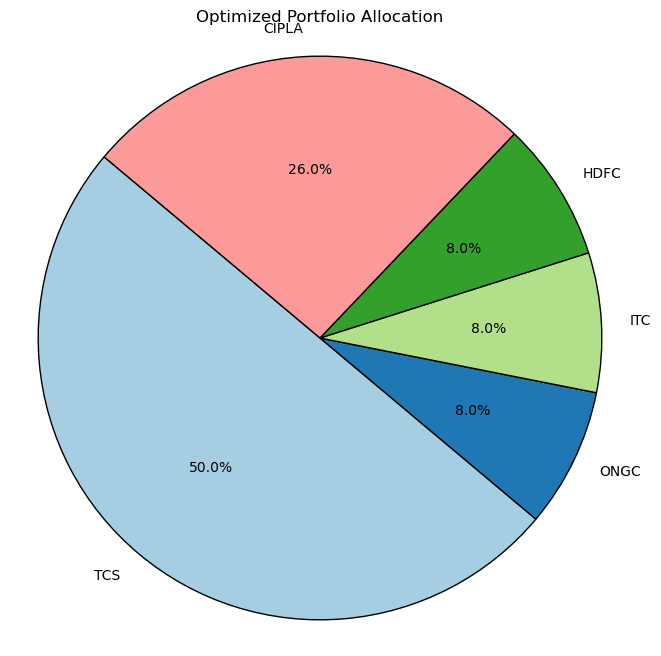

In [48]:
# Pie chart
plt.close('all')
optimized_weights = optimized_sharpe.x
plt.figure(figsize=(8, 8))
plt.pie(
    optimized_weights,
    labels=symbols,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors[:len(optimized_weights)], 
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Optimized Portfolio Allocation', fontsize=12)
plt.axis('equal')
plt.show()


### Value at Risk (VaR) and Conditional Value at Risk (CVaR)

To quantify downside risk, we calculate:

- **Value at Risk (VaR)**: the maximum expected loss with 95% confidence over one day.
- **Conditional Value at Risk (CVaR)**: the average loss **given** that the loss exceeds the VaR threshold.

We use the **historical simulation method**, which directly analyzes the distribution of past returns to estimate these values without assuming a normal distribution.

In [42]:
# Calculate daily portfolio returns using the optimized weights
portfolio_returns = log_return.dot(optimal_weights)

# Drop any NaN values just in case
portfolio_returns = portfolio_returns.dropna()

# Sort the returns
sorted_returns = portfolio_returns.sort_values()

# Set the confidence level
confidence_level = 0.95
alpha = 1 - confidence_level

# Calculate Historical VaR (5th percentile for 95% confidence)
VaR_95 = np.percentile(sorted_returns, 100 * alpha)

# Select returns worse than or equal to VaR
losses_beyond_var = sorted_returns[sorted_returns <= VaR_95]

# Calculate CVaR only if there are losses beyond VaR
if len(losses_beyond_var) > 0:
    CVaR_95 = losses_beyond_var.mean()
else:
    CVaR_95 = np.nan

# Print results
print("="*80)
print(f"Value at Risk (95% confidence): {VaR_95:.4f}")
print(f"Conditional Value at Risk (CVaR): {CVaR_95:.4f}")
print("="*80)


Value at Risk (95% confidence): -0.0206
Conditional Value at Risk (CVaR): -0.0386


### Risk Analysis Results: 

#### Value at Risk (VaR @ 95%) = –2.06%
There's a 5% chance that our portfolio could lose more than 2.06% in a single day under similar market conditions.

#### Conditional Value at Risk (CVaR) = –3.86%
If losses exceed the VaR threshold, the average loss could be about 3.86%.

## Project Summary

### Key Takeaways

- The optimizer initially suggested high allocation to a single stock (CIPLA), which we adjusted using bounds to ensure a **diversified and investable portfolio**.
- The **VaR** and **CVaR** metrics indicated that even an optimized portfolio carries **tail risk**, underscoring the importance of risk-aware investing.
- This project highlights the power of **Python, NumPy, Pandas, Matplotlib, and SciPy** in building a data-driven, realistic financial strategy.

### Conclusion

This end-to-end portfolio optimization project demonstrates how statistical analysis and financial theory can be practically applied to real-world market data. The methods used are scalable and can be extended to larger portfolios or different market conditions.